In [1]:
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
import torch
import umap
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd


if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available on this device")
else:
    device = torch.device("cpu")
    print("MPS is not available, using CPU")


dataset = load_dataset("SALT-NLP/silent_signals")
print(dataset)

dataset = dataset["train"]
# as pandas dataframe

df = pd.DataFrame(dataset)


/Users/linozurmuhl/miniforge3/envs/NLP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MPS is available on this device
DatasetDict({
    train: Dataset({
        features: ['dog_whistle', 'dog_whistle_root', 'ingroup', 'content', 'date', 'speaker', 'chamber', 'subreddit', 'source', 'definition', 'type', 'party'],
        num_rows: 16258
    })
})


In [2]:
# function that drops duplicates but saves those dropped instances in a separate data frame
def drop_duplicates_save(df):
    duplicates = df[df.duplicated(subset=["content"], keep=False)]
    df = df.drop_duplicates(subset=["content"])
    # drop missing values in lable and content
    df = df.dropna(subset=["content"])
    if "lable" in df.columns:
        df = df.dropna(subset=["lable"])
    return df, duplicates


In [3]:
# filter out the informal and formal sentences
df_informal = df[df["type"] == "Informal"]
df_formal = df[df["type"] == "Formal"]
print('With duplicates:', df_informal.shape, df_formal.shape)
# drop duplicates
df_informal, duplicates_if_1 = drop_duplicates_save(df_informal)
df_formal, duplicates_f_1 = drop_duplicates_save(df_formal)
print('Without duplicates:', df_informal.shape, df_formal.shape)

With duplicates: (12923, 12) (3335, 12)
Without duplicates: (12901, 12) (3298, 12)


In [4]:
# load csv 
null_dataset_formal = pd.read_csv("0_data/formal_neg_predictions.csv")
null_dataset_informal = pd.read_csv("0_data/informal_neg_predictions.csv")

/var/folders/vx/1wqkklmd4qzbv02gbc6344wc0000gn/T/ipykernel_27838/3446518005.py:2: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  null_dataset_formal = pd.read_csv("0_data/formal_neg_predictions.csv")


In [5]:
print('With duplicates:', null_dataset_formal.shape, null_dataset_informal.shape)
# drop duplicates
null_dataset_informal, duplicates_if_0 = drop_duplicates_save(null_dataset_informal)
null_dataset_formal, duplicates_f_0 = drop_duplicates_save(null_dataset_formal)
print('Without duplicates:', null_dataset_formal.shape, null_dataset_informal.shape)

With duplicates: (33563, 16) (34360, 14)
Without duplicates: (33057, 16) (34212, 14)


In [6]:
# merge informal and formal datasets
null_dataset = pd.concat([null_dataset_formal, null_dataset_informal])

In [7]:
# EDA
print(null_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 67269 entries, 0 to 34359
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dog_whistle       67269 non-null  object 
 1   dog_whistle_root  67269 non-null  object 
 2   ingroup           67269 non-null  object 
 3   content           67269 non-null  object 
 4   date              67269 non-null  object 
 5   speaker           33045 non-null  object 
 6   chamber           33057 non-null  object 
 7   community         16 non-null     object 
 8   speech_id         26072 non-null  float64
 9   party             29590 non-null  object 
 10  speaker_bioguide  28 non-null     object 
 11  definition        67269 non-null  object 
 12  source            67091 non-null  object 
 13  in_group          40975 non-null  object 
 14  type              67269 non-null  object 
 15  lable             67269 non-null  float64
 16  subreddit         34196 non-null  object 
dty

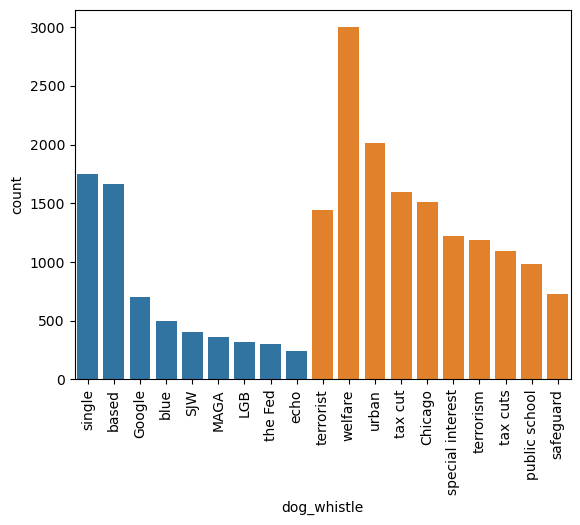

In [8]:
# count plot of informal dog_whistle and formal dog_whistle
import seaborn as sns
# split informal and formal into two bars 
# only the top 10 dog_whistles
sns.countplot(x='dog_whistle', data=null_dataset_informal, order=null_dataset_informal['dog_whistle'].value_counts().iloc[:10].index)
sns.countplot(x='dog_whistle', data=null_dataset_formal, order=null_dataset_formal['dog_whistle'].value_counts().iloc[:10].index)
# rotate x-axis labels
plt.xticks(rotation=90)
plt.show()

In [9]:
# join null informal data and original informal data
df_informal = pd.concat([df_informal, null_dataset_informal])

# label missing values as 1 in label column
df_informal['lable'] = df_informal['lable'].fillna(1)

# join null formal data and original formal data
df_formal = pd.concat([df_formal, null_dataset_formal])

# label missing values as 0 in label column
df_formal['lable'] = df_formal['lable'].fillna(1)

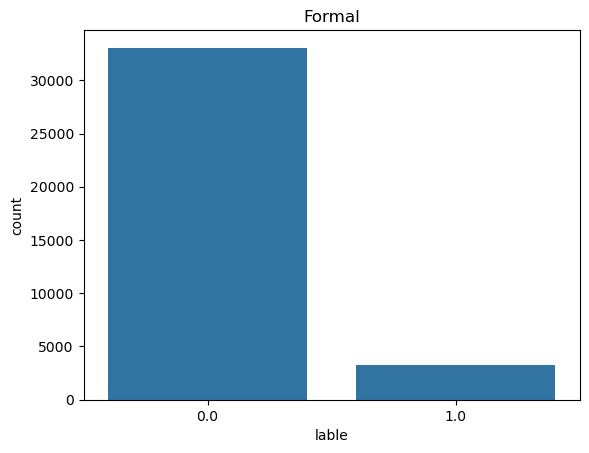

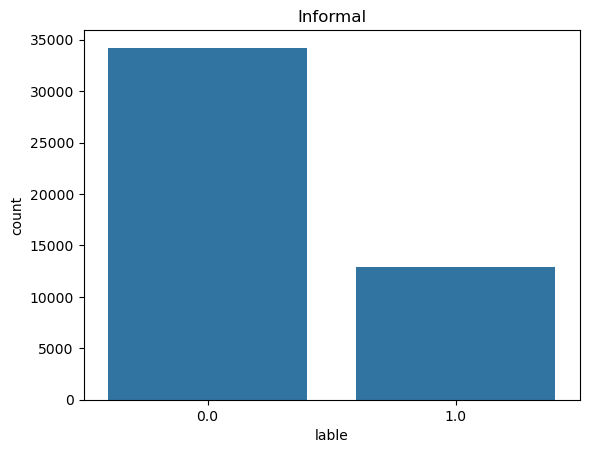

In [10]:
# count plot lable column of informal and formal in one plot 

sns.countplot(x='lable', data=df_formal)
plt.title('Formal')
plt.show()

sns.countplot(x='lable', data=df_informal)
plt.title('Informal')
plt.show()


In [11]:
import re
import string
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
import random
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, KFold
from cleanlab import Datalab


In [12]:
raw_texts = df_informal['content'].tolist()
labels = df_informal['lable'].tolist()
dog_whistles = df_informal['dog_whistle'].tolist()

In [13]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Configure PyTorch for deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-cased')
model = BertModel.from_pretrained('google-bert/bert-base-cased').to(device)

def get_embeddings_in_batches(texts, batch_size=32):
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize the batch of texts
        tokens = tokenizer(
            batch_texts, 
            padding=True, 
            truncation=True, 
            return_tensors='pt', 
            max_length=512
        ).to(device)

        # Generate BERT embeddings
        with torch.no_grad():
            outputs = model(**tokens)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling to get sentence embeddings

        # Move embeddings back to CPU and append to the list
        all_embeddings.append(embeddings.cpu().numpy())

    # Concatenate all embeddings into one numpy array
    return np.concatenate(all_embeddings, axis=0)

# Get embeddings for the dataset
embeddings_np_informal = get_embeddings_in_batches(raw_texts, batch_size=32)

# Define a cross-validation strategy with fixed random state
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# Train a classifier using cross-validation
clf = LogisticRegression(max_iter=1000, random_state=seed)
pred_probs = cross_val_predict(
    clf, embeddings_np_informal, labels, method="predict_proba", cv=cv
)

# Use Cleanlab's Datalab to find and report issues
data_dict = {"texts": raw_texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels")
lab.find_issues(pred_probs=pred_probs, features=embeddings_np_informal)
lab.report()


Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 7822 issues found in the dataset.
Dataset Information: num_examples: 47113, num_classes: 2

Here is a summary of various issues found in your data:

    issue_type  num_issues
         label        6514
       outlier        1142
near_duplicate         165
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having l

In [20]:
label_issues = lab.get_issues("label")
label_issues.head()

,is_label_issue,label_score,given_label,predicted_label
0,True,0.031014,1.0,0.0
1,True,0.106208,1.0,0.0
2,True,0.138911,1.0,0.0
3,True,0.038887,1.0,0.0
4,False,0.588963,1.0,1.0


In [28]:
identified_label_issues = label_issues[label_issues["is_label_issue"] == True]


In [34]:
data_with_suggested_labels = pd.DataFrame(
    {"dog_whistles": dog_whistles, "text": raw_texts, "given_label": labels, "suggested_label": label_issues["predicted_label"], "problem": identified_label_issues["is_label_issue"], "label_score": identified_label_issues["label_score"]}
)
potential_wrong_label = data_with_suggested_labels.dropna(subset=["problem"]).sort_values(by="label_score", ascending=False)

In [35]:
# save the potential wrong labels to a csv file
potential_wrong_label.to_csv("vetting_instances/potential_wrong_label.csv")

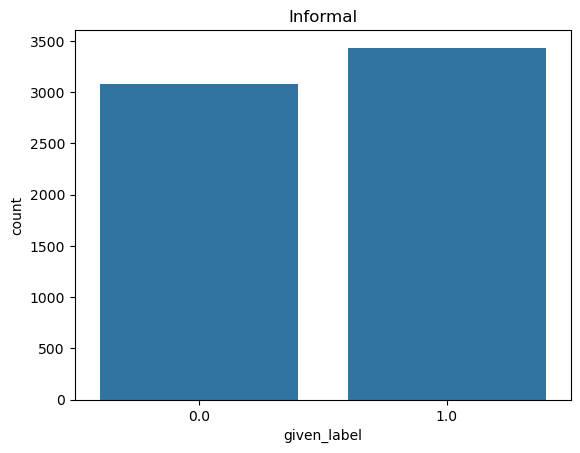

In [32]:
sns.countplot(x='given_label', data=potential_wrong_label)
plt.title('Informal')
plt.show()

In [19]:
nd_issues = lab.get_issues("near_duplicate")
identified_nd_issues = nd_issues[nd_issues["is_near_duplicate_issue"] == True]
identified_nd_issues = identified_nd_issues.sort_values("near_duplicate_score")

identified_nd_issues.head()


,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
36495,True,0.000010,"[33408, 33407, 24592, 967]",4.768372e-07
33408,True,0.000010,"[36495, 33407, 24592, 967]",4.768372e-07
967,True,0.000179,"[24592, 33408, 36495, 33407]",8.285046e-06
24592,True,0.000179,"[967, 33408, 36495, 33407]",8.285046e-06
33407,True,0.000228,"[36495, 33408, 24592, 967]",1.055002e-05
